# Trend and Anomaly Analyses of Spatiotemporal Dataset

**Trend** and **anomaly** analyses are widely used in Earth Science research for detecting long term change.

We present an example, in which linear trend of sea surface temperature (SST) is calculated.

We will use the [NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) product, a widely used and trusted gridded compilation of of historical data going back to 1854.

## 1. Load basic libs

In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
from numpy import nan
import sys
import warnings
import math
from glob import glob
import matplotlib.pyplot as plt

## 2. Read SST data

In [2]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1982', '2016'))
ds

<xarray.Dataset> Size: 27MB
Dimensions:  (lat: 89, lon: 180, time: 420)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 3kB 1982-01-01 1982-02-01 ... 2016-12-01
Data variables:
    sst      (time, lat, lon) float32 27MB ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-11-03
    DODS_EXTRA.Unlimited_Dimension:  time

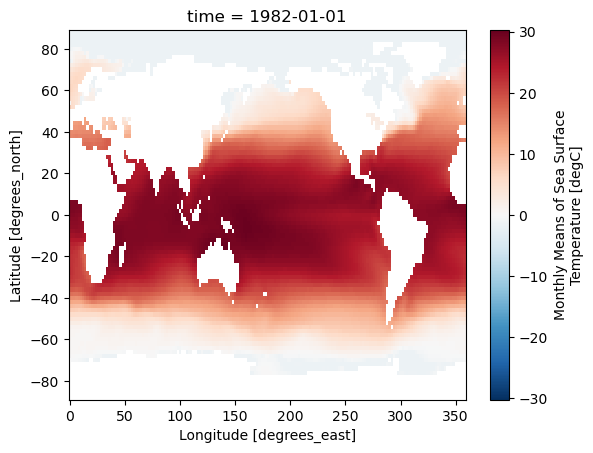

In [4]:
# check the dataset - NaN over the land
ds.sst[0].plot()

In [5]:
lons = ds.lon
lats = ds.lat
sst = ds.sst
nctime = ds.time

nt, nlat, nlon = sst.shape
ngrd = nlon*nlat

## 3. Trend Analysis

Here we present two ways of calculating linear trend. 

The first method is by using function [`np.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html). The basic syntax is `p = np.polyfit(x,y,deg)` with `deg = 1` for linear regression.

The second method is by using function 
[`stats.linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) in SciPy. The basic syntax is `slope, intercept, r, p, se = stats.linregress(x, y)`.

### 3.1a Linear trend calculation with `np.polyfit`

In [6]:
# first set up x and y
# for y, reshape sst to a matrix of nt-by-ngrd

sst_grd  = ds.sst.values.reshape((nt, ngrd)) 
x        = np.linspace(1,nt,nt)
sst_trend1 = np.empty((ngrd,1))
sst_trend1[:,:] = np.nan

In [7]:
for i in range(ngrd): 
    y = sst_grd[:,i]   
    if (not np.isnan(y[0])):  # calculation is only done over the ocean grids, not land grids (nan)
        z = np.polyfit(x, y, 1) 
        sst_trend1[i,0] = z[0]*120.0  
        # the unit for z[0] is degC per month, multiply by 120 to get a unit of degC per decade

sst_trend1 = sst_trend1.reshape((nlat,nlon))

### 3.1b Linear trend calculation with `stats.linregress`

In [8]:
import scipy.stats as stats

sst_grd  = ds.sst.values.reshape((nt, ngrd)) 
x        = np.linspace(1,nt,nt)
sst_trend2 = np.empty((ngrd,1))
sst_trend2[:,:] = np.nan

In [9]:
for i in range(ngrd): 
    y = sst_grd[:,i]   
    if (not np.isnan(y[0])): 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        sst_trend2[i,0] = slope*120.0     
    
sst_trend2 = sst_trend2.reshape((nlat,nlon))

### 3.2 Visualize SST trend

Text(0, 0.5, '$^oC$/decade')

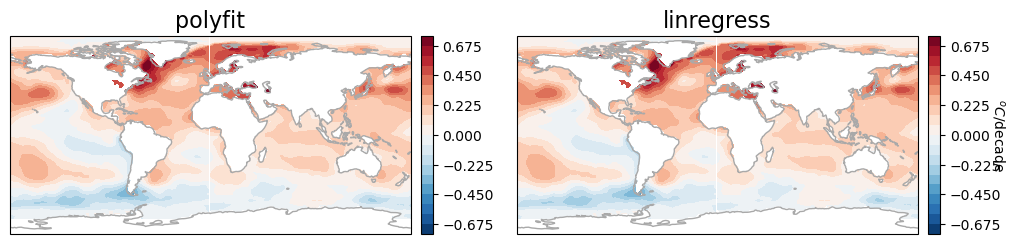

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, axes = plt.subplots(ncols=2, 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(12,9))
ax0, ax1 = axes

clevs = np.linspace(-0.75, 0.75, 21)
cs = ax0.contourf(lons, lats, sst_trend1, clevs, cmap=plt.cm.RdBu_r)
ax0.coastlines(color='darkgray', linewidth=1)
ax0.set_title('polyfit', fontsize=16)
cax0 = make_axes_locatable(ax0).append_axes("right", size="3%", pad=0.1, axes_class=plt.Axes)
cbar = plt.colorbar(cs, cax=cax0, orientation='vertical') 

cs = ax1.contourf(lons, lats, sst_trend2, clevs, cmap=plt.cm.RdBu_r)
ax1.coastlines(color='darkgray', linewidth=1)
ax1.set_title('linregress', fontsize=16)
cax1 = make_axes_locatable(ax1).append_axes("right", size="3%", pad=0.1, axes_class=plt.Axes)
cbar = plt.colorbar(cs, cax=cax1, orientation='vertical')
cbar.ax.set_ylabel('$^oC$/decade', rotation=270)